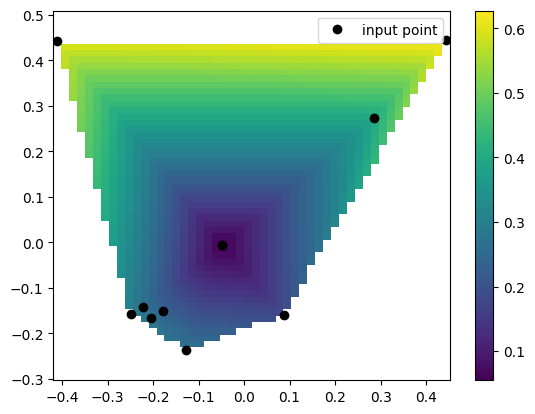

In [ ]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5
z = np.hypot(x, y)
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = LinearNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

In [2]:
import os
import numpy as np
import cupy as cp
from PIL import Image
from cupyx.scipy.spatial import Delaunay
from cupyx.scipy.interpolate import LinearNDInterpolator
from cupy.cuda import Event


In [3]:

def save_gray(arr: np.ndarray, name: str, save_folder: str, max_depth: float):
    """把深度图归一化到 [0,255] 并保存为 PNG。"""
    img = np.nan_to_num(arr, nan=0.0)
    img = (img / max_depth * 255.0).clip(0, 255).astype(np.uint8)
    im = Image.fromarray(img)
    im.save(os.path.join(save_folder, f"{name}.png"))


In [ ]:
input_folder = "/home/qinllgroup/hongxiangyu/git_project/livo2-data-utils/11-Mesh-gpu/data/tree_01_mini/depth_maps"
output_folder = "/home/qinllgroup/hongxiangyu/git_project/livo2-data-utils/11-Mesh-gpu/data/tree_01_mini/depth_mesh"

num_bins = int(15)
max_edge = 10
max_depth = 30


save_path = os.path.join(output_folder, "stack_gpu") # args.func
json_path = os.path.join(save_path, "time_json")

os.makedirs(save_path, exist_ok=True)
os.makedirs(json_path, exist_ok=True)


for fname in os.listdir(input_folder):
    img = Image.open(os.path.join(input_folder, fname))
    img_arr = (np.array(img) / 255.0 * max_depth).astype(np.float32)
    h, w = img_arr.shape
    depth_map = cp.asarray(img_arr, dtype=cp.float32)
    
    # 1. 提取有效散点
    ys, xs = cp.nonzero(depth_map > 0)
    depths = depth_map[ys, xs]
    pts = cp.stack([xs, ys], axis=1)
    
    # 2.分bin
    overlap = 0.2 # 重叠部分 0.2 m useless
    d_min, d_max = float(depths.min()), float(depths.max())
    edges = cp.linspace(d_min, d_max, num_bins + 1)
    
    final_depth = cp.full_like(depth_map, cp.nan)
    prev_points = cp.array([]).reshape(0, 2)
    prev_depths = cp.array([])
    
    mask = cp.zeros((h, w), dtype=bool)
    for i in range(num_bins):
        low, high = edges[i], edges[i + 1]
        valid_mask = (depth_map >= low) & (depth_map < high) & (~mask)
        if not cp.any(valid_mask):
            continue
        
        u, v = cp.where(valid_mask)
        depths = depth_map[valid_mask]
        points = cp.column_stack((v, u))
        
        all_points = cp.vstack((prev_points, points))
        all_depths = cp.hstack((prev_depths, depths))
        
        prev_mask = (depth_map >= (high-0.2)) & (depth_map < high) & (~mask)
        prev_u,prev_v = cp.where(prev_mask)
        prev_depths = depth_map[prev_mask]
        prev_points = cp.column_stack((prev_v,prev_u))
        
        # 三角剖分
        tri = Delaunay(all_points)
        
        simplices = tri.simplices
        pts = all_points[simplices]
        edges = pts - pts[:, [1, 2, 0], :]  
        edge_lengths = cp.linalg.norm(edges, axis=2)
        max_edge_lengths = cp.max(edge_lengths, axis=1)
        valid_tris_mask = max_edge_lengths <= max_edge
        valid_tris = simplices[valid_tris_mask]
        if valid_tris.shape[0] == 0:
            continue
        interpolator = LinearNDInterpolator(all_points, all_depths)
        xs_all, ys_all = cp.meshgrid(cp.arange(w), cp.arange(h))
        query_pts = cp.stack([xs_all.ravel(), ys_all.ravel()], axis=1)
        depth_all = interpolator(query_pts)
        
        simp_idx = tri.find_simplex(query_pts)
        mask_valid_edge = (simp_idx >= 0)
        
        mask_valid_edge[mask_valid_edge] &= valid_tris[simp_idx[mask_valid_edge]]
        depth_all[~mask_valid_edge] = cp.nan # 去除插值后无效点处深度
        
        new_region = (~cp.isnan(depth_all)) & (~mask)
        final_depth[new_region] = depth_all[new_region]
        mask |= new_region
    final_depth = cp.where(mask, final_depth, depth_map)
    
    save_gray(cp.asnumpy(final_depth), f"{fname}-final", save_path, max_depth)

In [ ]:

def process_folder(
    input_folder: str,
    output_folder: str,
    num_bins: int = 5,
    max_edge: float = 50.0,
    debug: bool = False
):
    os.makedirs(output_folder, exist_ok=True)
    # 遍历输入文件
    for fname in os.listdir(input_folder):
        if not fname.lower().endswith('.png'):
            continue
        # 1. 读取图像并转为 GPU 数组
        img = Image.open(os.path.join(input_folder, fname)).convert('L')
        arr = np.array(img)
        h, w = arr.shape
        depth_gpu = cp.asarray(arr, dtype=cp.float32)

        # 提取有效散点
        ys, xs = cp.nonzero(depth_gpu > 0)
        depths = depth_gpu[ys, xs]
        pts = cp.stack([xs, ys], axis=1)

        # 计算深度范围并划分 bins
        d_min, d_max = float(depths.min()), float(depths.max())
        bins = cp.linspace(d_min, d_max, num_bins + 1)

        final_depth = cp.zeros((h, w), dtype=cp.float32)

        # 逐 bin 处理
        for i in range(num_bins):
            low, high = bins[i], bins[i+1]
            mask_bin = (depths >= low) & (depths < high)
            if not bool(mask_bin.any()):
                continue
            pts_bin = pts[mask_bin]
            depth_bin = depths[mask_bin]

            # 计时：三角剖分
            start_tri, end_tri = Event(), Event()
            start_tri.record()
            tri = Delaunay(pts_bin)
            end_tri.record()
            tri_time = cp.cuda.get_elapsed_time(start_tri, end_tri)

            simplices = tri.simplices

            # 过滤：边长阈值
            max_edge_sq = max_edge ** 2
            v0 = pts_bin[simplices[:,0]]
            v1 = pts_bin[simplices[:,1]]
            v2 = pts_bin[simplices[:,2]]
            l01 = cp.sum((v0 - v1) ** 2, axis=1)
            l12 = cp.sum((v1 - v2) ** 2, axis=1)
            l20 = cp.sum((v2 - v0) ** 2, axis=1)
            valid_tri = (l01 <= max_edge_sq) & (l12 <= max_edge_sq) & (l20 <= max_edge_sq)
            simplices_f = simplices[valid_tri]

            # 计时：插值
            start_int, end_int = Event(), Event()
            start_int.record()
            interpolator = LinearNDInterpolator(pts_bin, depth_bin)
            xs_all, ys_all = cp.meshgrid(cp.arange(w), cp.arange(h))
            query_pts = cp.stack([xs_all.ravel(), ys_all.ravel()], axis=1)
            depth_all = interpolator(query_pts)
            # 掩码无效三角
            simp_idx = tri.find_simplex(query_pts)
            mask_valid = (simp_idx >= 0)
            depth_all[~mask_valid] = 0
            end_int.record()
            int_time = cp.cuda.get_elapsed_time(start_int, end_int)

            # 调试可视化
            if debug:
                # 散点图
                dbg_pts = cp.zeros((h, w), dtype=cp.uint8)
                dbg_pts[ys[mask_bin], xs[mask_bin]] = 255
                Image.fromarray(cp.asnumpy(dbg_pts)).save(
                    os.path.join(output_folder, f'{fname}_bin{i}_pts.png')
                )
                # 全插值图
                dbg_all = depth_all.reshape(h, w).astype(cp.uint8)
                Image.fromarray(cp.asnumpy(dbg_all)).save(
                    os.path.join(output_folder, f'{fname}_bin{i}_interp.png')
                )
                # 掩码后插值图
                dbg_mask = cp.zeros((h*w,), dtype=cp.uint8)
                dbg_mask[mask_valid] = depth_all[mask_valid].astype(cp.uint8)
                dbg_mask = dbg_mask.reshape(h, w)
                Image.fromarray(cp.asnumpy(dbg_mask)).save(
                    os.path.join(output_folder, f'{fname}_bin{i}_masked.png')
                )

            # 深度融合（近覆盖远）
            depth_map = depth_all.reshape(h, w)
            final_depth = cp.where(depth_map > 0, depth_map, final_depth)

            # 打印或记录每步耗时
            print(f'{fname} bin[{i}] tri: {tri_time:.2f}ms, interp: {int_time:.2f}ms')

        # 保存最终深度图
        fd_norm = (final_depth - float(final_depth.min())) / (float(final_depth.max()) - float(final_depth.min()) + 1e-8)
        fd_img = (fd_norm * 255).astype(cp.uint8)
        Image.fromarray(cp.asnumpy(fd_img)).save(
            os.path.join(output_folder, f'{fname}_final.png')
        )

if __name__ == '__main__':
    process_folder('input_depths', 'output_mesh', num_bins=8, max_edge=30.0, debug=True)
